In [31]:
import astropy.units as u
import astropy.wcs
import h5py
import matplotlib.pyplot as plt
import ndcube
from ndcube import NDCube
import numpy as np
from synthesizAR.instruments.util import extend_celestial_wcs
import warnings
import numpy as np
import sunpy
from sunpy.map import Map
from astropy.io import fits 
import glob
import os
from matplotlib import colors
import scipy.optimize as so

In [71]:
# Code for plotting contours
#from https://gist.github.com/adrn/3993992

def find_confidence_interval(x, pdf, confidence_level):
    return pdf[pdf > x].sum() - confidence_level

def density_contour(xdata, ydata, nbins_x, nbins_y, ax=None, **contour_kwargs):
    """ Create a density contour plot.
    Parameters
    ----------
    xdata : numpy.ndarray
    ydata : numpy.ndarray
    nbins_x : int
        Number of bins along x dimension
    nbins_y : int
        Number of bins along y dimension
    ax : matplotlib.Axes (optional)
        If supplied, plot the contour to this axis. Otherwise, open a new figure
    contour_kwargs : dict
        kwargs to be passed to pyplot.contour()
        
    Example Usage
    -------------
     density_contour(x pos, y pos, contour res, contour res, axis, colors for contours)
     e.g.:
     density_contour(xD, yD, 80, 80, ax=ax, 
         colors=['red','orange', 'yellow', 'orange', 'yellow'])
    """
    H, xedges, yedges = np.histogram2d(xdata, ydata, bins=(nbins_x,nbins_y),density=True)
    x_bin_sizes = (xedges[1:] - xedges[:-1]).reshape((1,nbins_x))
    y_bin_sizes = (yedges[1:] - yedges[:-1]).reshape((nbins_y,1))

    pdf = (H*(x_bin_sizes*y_bin_sizes))
    
    X, Y = 0.5*(xedges[1:]+xedges[:-1]), 0.5*(yedges[1:]+yedges[:-1])
    Z = pdf.T
    fmt = {}
    
    ### Adjust Here #### 
    '''
    # Contour Levels Definitions
    one_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.68))
    two_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.95))
    three_sigma = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.99))
    
    # You might need to add a few levels
    sub_sigma1 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.75))
    sub_sigma2 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.80))
    sub_sigma3 = so.brentq(find_confidence_interval, 0., 1., args=(pdf, 0.90))

    # Array of Contour levels. Adjust according to the above
    levels = [one_sigma, sub_sigma1, sub_sigma2, sub_sigma3, two_sigma, three_sigma][::-1]
    
    # contour level labels  Adjust accoding to the above.
    strs = ['0.68','0.75', '0.80', '0.90','0.95', '0.99'][::-1]
    '''
    #lev1 = so.brentq(find_confidence_interval, 0.,1.,args=(pdf,0.1))
    lev2 = so.brentq(find_confidence_interval, 0.,1.,args=(pdf,0.1)) #was 0.2
    lev3 = so.brentq(find_confidence_interval, 0.,1.,args=(pdf,0.2))
    lev4 = so.brentq(find_confidence_interval, 0.,1.,args=(pdf,0.5)) #was not 
    #lev5 = so.brentq(find_confidence_interval, 0.,1.,args=(pdf,0.8)) #was not
    #lev6 = so.brentq(find_confidence_interval, 0.,1.,args=(pdf,0.95))
    #changing levels

    levels = [lev2,lev3, lev4][::-1]
              #,lev4,lev5][::-1]
    strs = ['0.1','0.20','0.50'][::-1]
            #,'0.60','0.80'][::-1]

    
    ###### 
    
    if ax == None:
        contour = plt.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        plt.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)

    else:
        contour = ax.contour(X, Y, Z, levels=levels, origin="lower", **contour_kwargs)
        for l, s in zip(contour.levels, strs):
            fmt[l] = s
        ax.clabel(contour, contour.levels, inline=True, fmt=fmt, fontsize=12)
    
    return contour

In [76]:
#creating timelag map with cross correlation
def single_histo(frequency, channels, ax, lag_range): # frequency can be high, inter, low , channels are in form #_# , em is either high_em, inter_em, or low_em
    #read in em map
    em = sunpy.map.Map('/Users/avathienel/NASA/synthetic-observables-paper-models/paper/data/'+frequency+'_frequency/'+frequency+'_slope_map.fits')
    #read in r squared values
    r_val = sunpy.map.Map('/Users/avathienel/NASA/synthetic-observables-paper-models/paper/data/'+frequency+'_frequency/'+frequency+'_r_squared_map.fits')
    em.mask = r_val.data < 0.75 
    #read in correlation
    corr = sunpy.map.Map('/Users/avathienel/NASA/synthetic-observables-paper-models/paper/data/'+frequency+'_frequency/correlation_'+channels+'.fits')
    #read in timelag
    lag = sunpy.map.Map('/Users/avathienel/NASA/synthetic-observables-paper-models/paper/data/'+frequency+'_frequency/timelag_'+channels+'.fits')
    lag.mask = corr.data < 0.1
    #define mask
    combined_mask = em.mask | lag.mask
    #apply combined mask
    y_coords = em.data[~combined_mask] 
    x_coords = lag.data[~combined_mask]
    #plot
    #fig, ax = plt.subplots()
    ax.grid
    ax.set_xlabel('timelag (s)')
    ax.set_ylabel('alpha')
    
    im = ax.hist2d(x_coords, y_coords, bins = 100, range = [lag_range, [1, 8]], 
              norm=colors.LogNorm()) #extract density somehow
    cb = fig.colorbar(im[3], ax=ax)
    density_contour(x_coords, y_coords, 100, 100, ax=ax, colors = ['red', 'blue', 'yellow'])



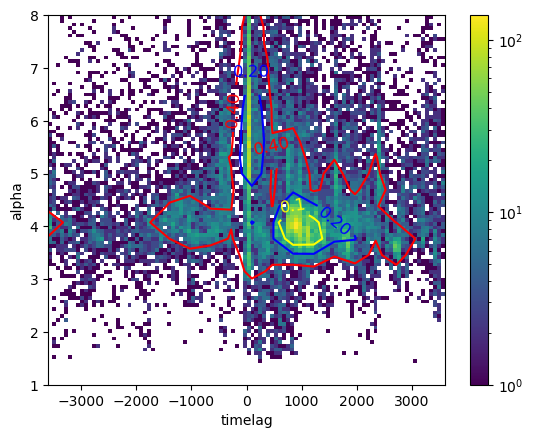

In [52]:
#example
fig, ax1 = plt.subplots()
high_94_171 = single_histo('high', '94_171', ax1, [-3600, 3600])

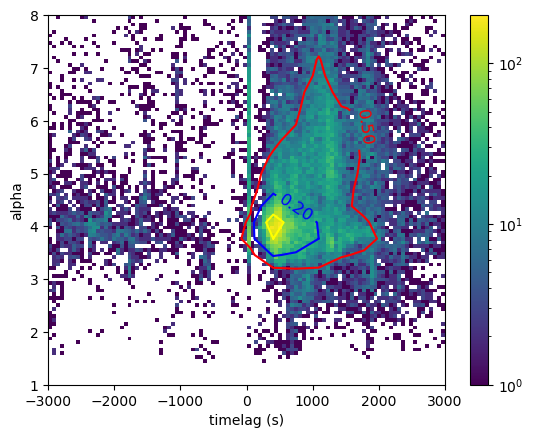

In [77]:
#example
fig, ax2 = plt.subplots()
high_94_171 = single_histo('high', '335_193', ax2, [-3000, 3000])

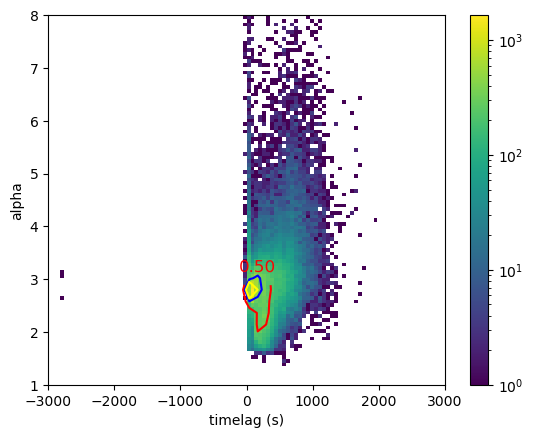

In [80]:
#example
fig, ax3 = plt.subplots()
high_94_171 = single_histo('intermediate', '211_193', ax3, [-3000, 3000])

In [58]:
def compare_freq(channels, ax, lag_range):
    #create plots data will be shown in
    #create 3 single histogram which shows all three frequencies of a single channel
    high_plt = single_histo('high', channels, ax[0], lag_range)
    ax[0].set_title('high freq.'+channels)
    inter_plt = single_histo('intermediate', channels, ax[1], lag_range)
    ax[1].set_title('inter freq.'+channels)
    low_plt = single_histo('low', channels, ax[2], lag_range)
    ax[2].set_title('low freq.'+channels)
    #adjust display spacing
    fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.9)
    fig.suptitle('Channel Pair: '+channels)

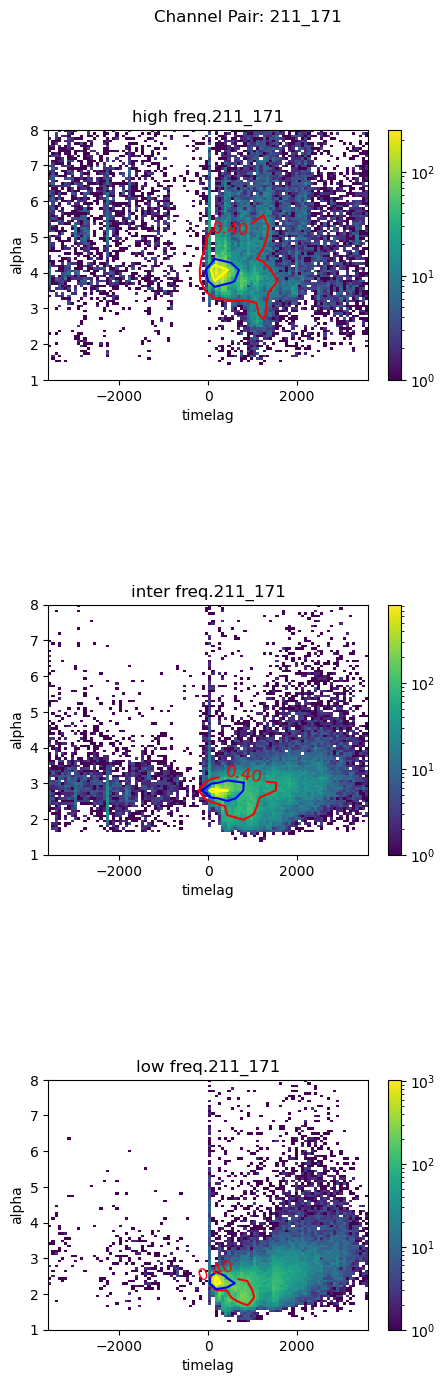

In [59]:
#example
fig, ax5 = plt.subplots(3,1, figsize = (5,15))
freq_211_171 = compare_freq('211_171', ax5, [-3600, 3600])

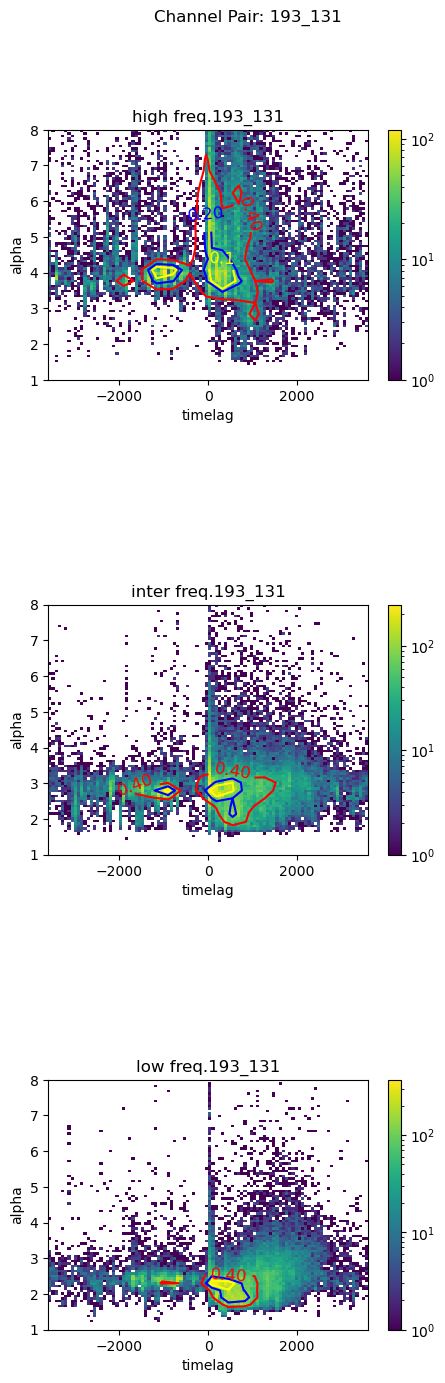

In [61]:
fig, ax6 = plt.subplots(3,1, figsize = (5,15))
compare_freq('193_131', ax6, [-3600, 3600])

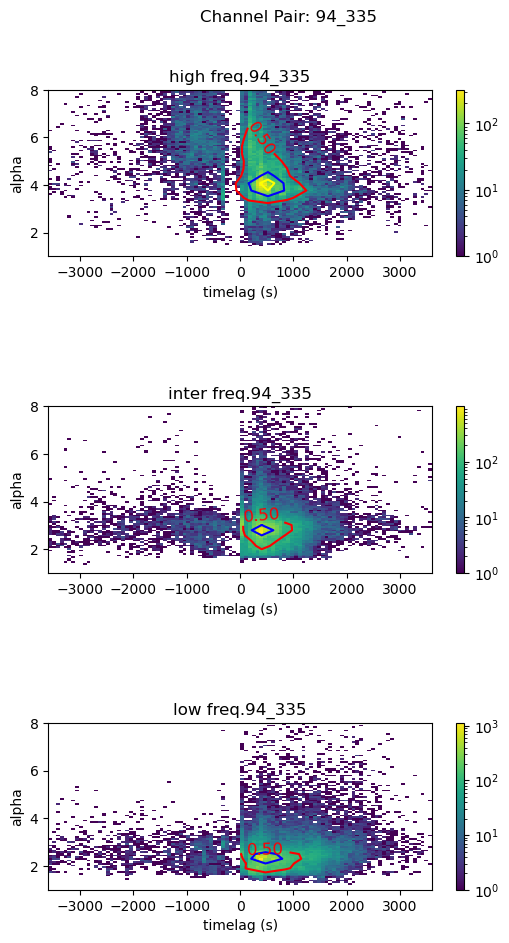

In [86]:
fig, ax7 = plt.subplots(3,1, figsize = (6,10))
compare_freq('94_335', ax7, [-3600, 3600])

In [63]:
def compare_lags(lag_list, lag_range): #list of channel pairs
    #create plots data will be shown in
    fig, axs = plt.subplots(len(lag_list), 3, figsize = (35, 6*(len(lag_list))))
    #displays frequency histograms for any channels next to eachother
    for i in range(len(lag_list)):
        compare_freq(lag_list[i], axs[i,:], lag_range)
    fig.suptitle('Time Lag Comparisons:',  x=0.3, fontsize=20)
    #adjust display spacing
    fig.subplots_adjust(left=0.1, right=0.6, bottom=0.3, top=0.95, hspace=0.5)
    #save figure
    #fig.savefig('/Users/avathienel/NASA/Frequency_Comparisions/compare_all.pdf')

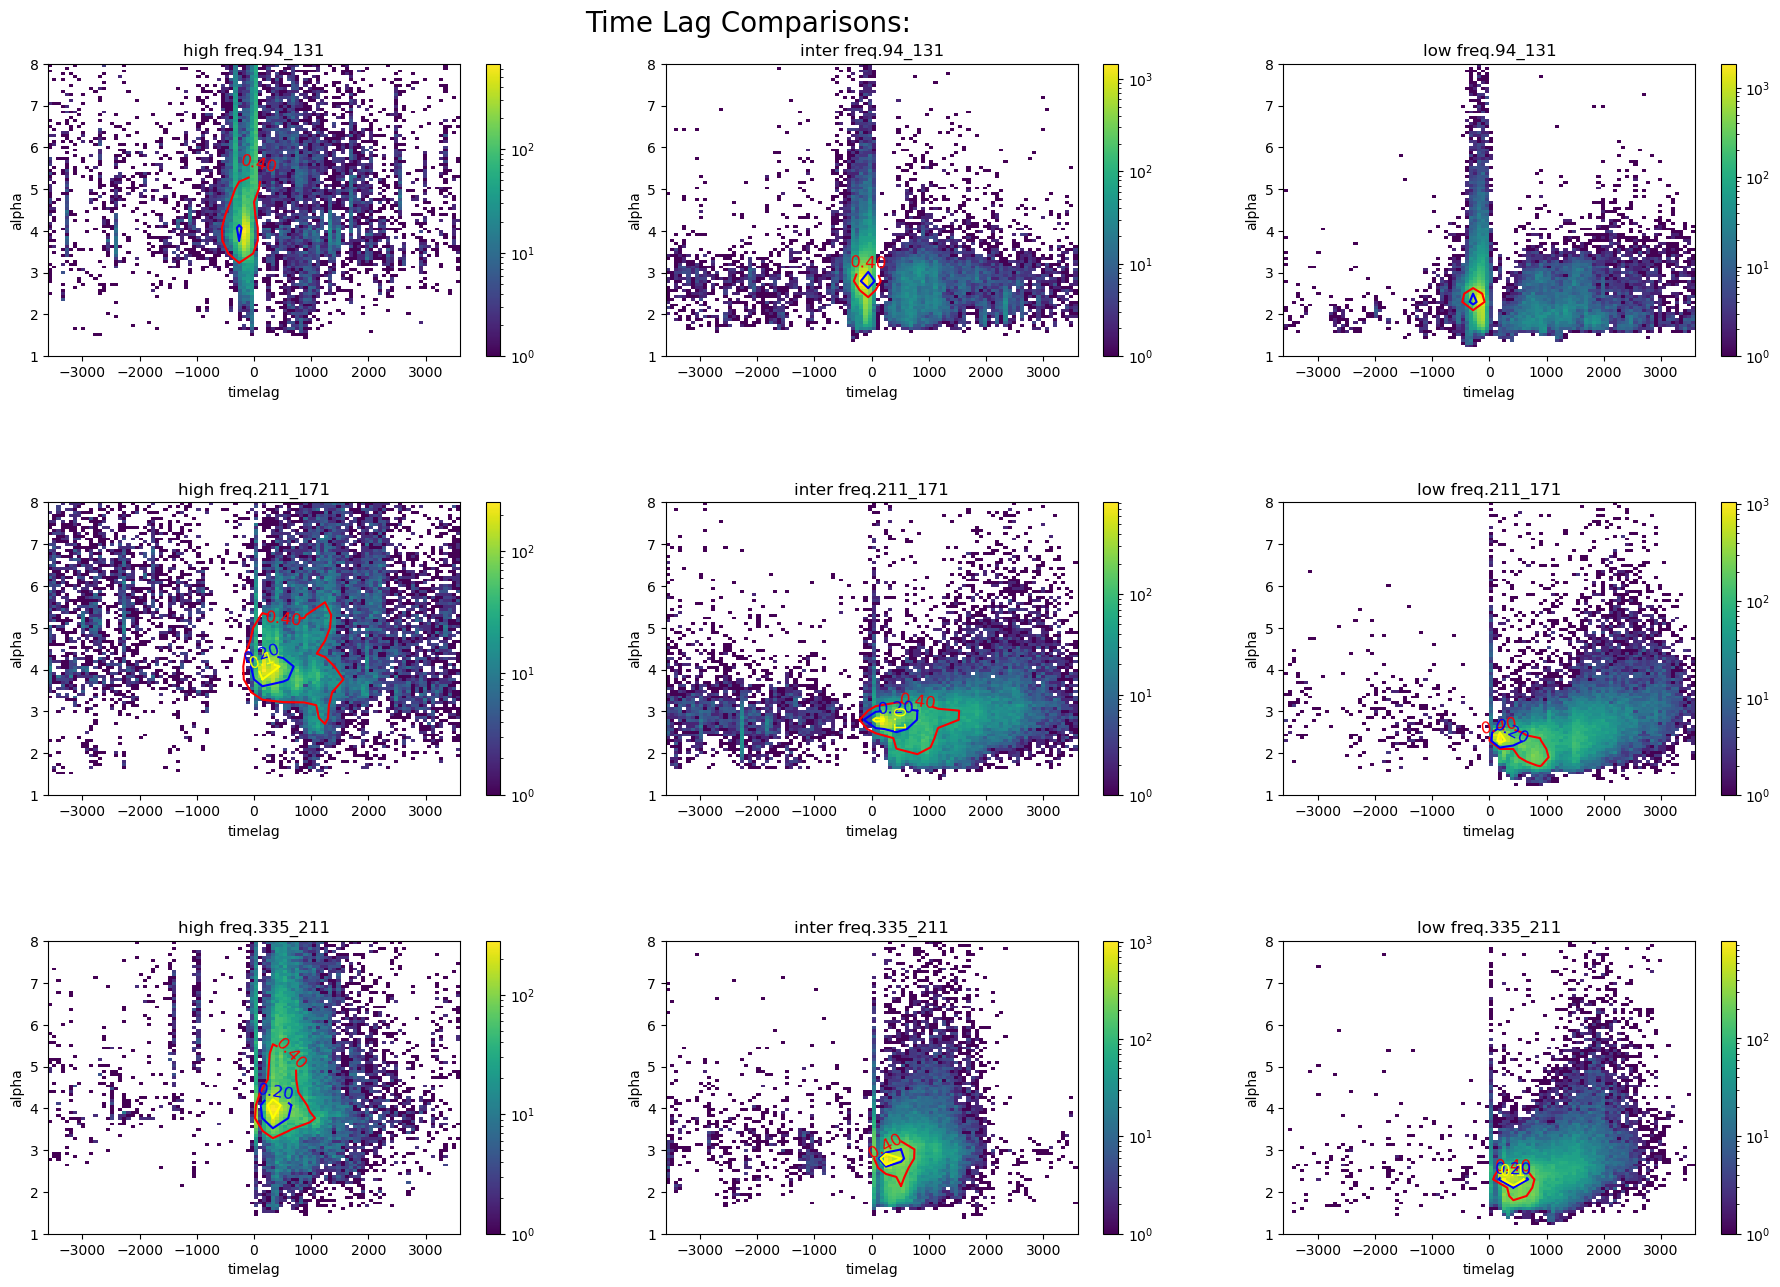

In [67]:
compare_lags(['94_131', '211_171', '335_211'], [-3600, 3600])

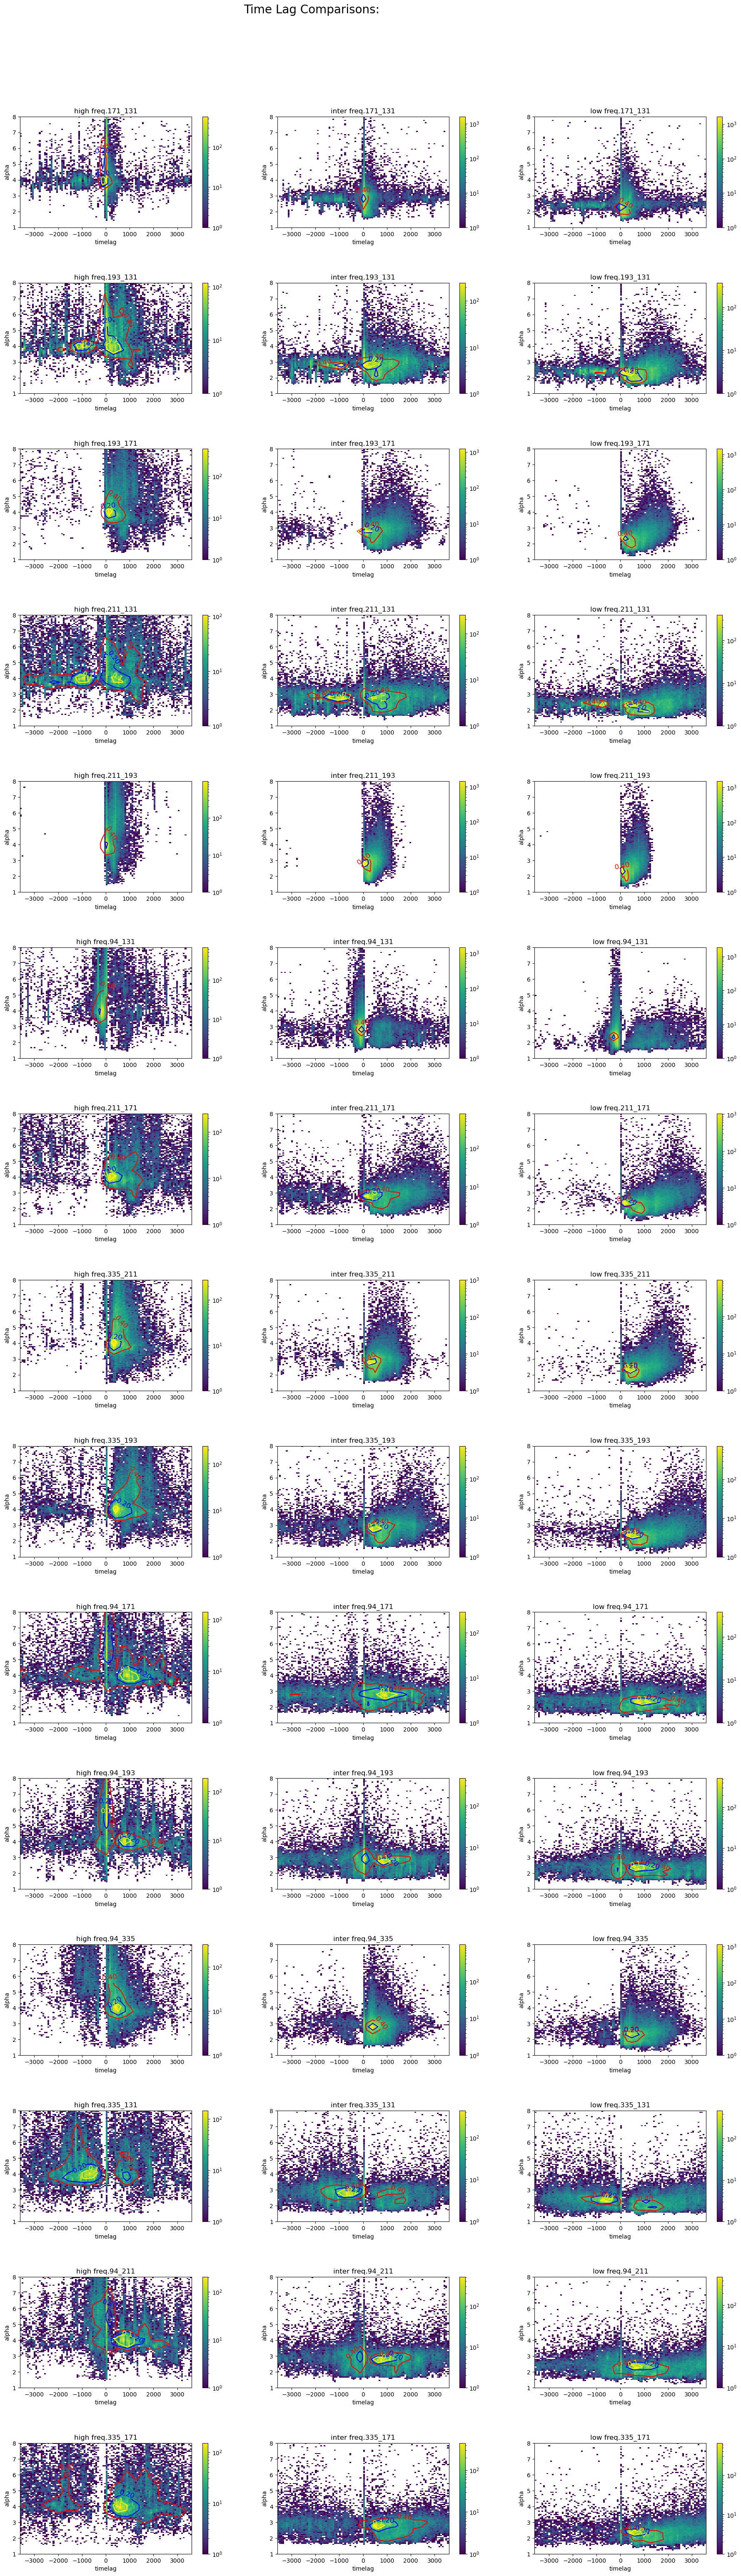

In [68]:
compare_lags(['171_131', '193_131', '193_171', '211_131', '211_193', '94_131', '211_171', '335_211', '335_193', '94_171', '94_193', '94_335', '335_131', '94_211', '335_171'], [-3600, 3600])
fig.savefig('/Users/avathienel/NASA/Frequency_Comparisions/compare_all_knots.pdf')
#compare_lags(['171_131', '193_131', '193_171', '211_131'], axs, 10, [-10000, 10000])